# Neural Network Classification with PyTorch

### Make custom data

In [219]:
import sklearn
from sklearn.datasets import make_circles

# make 1000 samples
n_samples = 1000

# create circle
X, y = make_circles(n_samples, noise = 0.03, random_state = 42)

In [220]:
len(X)

1000

In [221]:
len(y)

1000

In [222]:
print(f"Five samples of X: {X[:5]}")
print(f"Five samples of y: {y[:5]}")

Five samples of X: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
Five samples of y: [1 1 1 1 0]


In [223]:
# make a dataframe of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:, 1], "label": y})

In [224]:
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


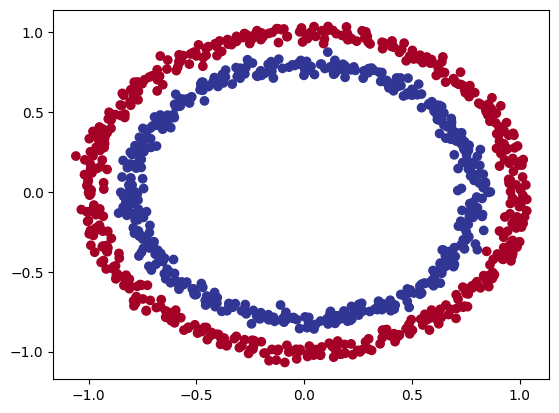

In [225]:
# Visualize
import matplotlib.pyplot as plt

plt.scatter(x=X[:,0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

This dataset is also called a toy dataset. A dataset that is small but also large enough for practice

### Check input and output shape

In [226]:
X.shape

(1000, 2)

In [227]:
y.shape

(1000,)

In [228]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [229]:
X.dtype

torch.float32

In [230]:
# Splitting data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [231]:
print(f"Shape of the train data is (X_train): {X_train.shape}")
print(f"Shape of the test data is (X_test): {X_test.shape}")
print(f"Shape of the train label is (y_train): {y_train.shape}")
print(f"Shape of the test label is (y_test): {y_test.shape}")

Shape of the train data is (X_train): torch.Size([800, 2])
Shape of the test data is (X_test): torch.Size([200, 2])
Shape of the train label is (y_train): torch.Size([800])
Shape of the test label is (y_test): torch.Size([200])


## Building the model
To classify the red and blue dot

In [232]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Costruct a model that subclassing `nn.Module`

In [233]:
class CircleModuleV0(nn.Module):
    def __init__(self):
        super().__init__()
        # create two nn.linear layers capable of hanlonh out data
        self.layer_1 = nn.Linear(in_features=2, out_features=5) # takes in 2 inpit features and upscales to 5 features
        self.layer_2 = nn.Linear(in_features=5, out_features= 1) # output layer
    # define a forward
    def forward(self, x):
        return self.layer_2(self.layer_1(x)) # x --> layer_1 --> layer-2 -->output
model_0 = CircleModuleV0()
model_0


CircleModuleV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

### REeplicating above with `nn.Sequential()`

In [234]:
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features= 5, out_features=1)
)
model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [235]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('0.bias', tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('1.bias', tensor([-0.1213]))])

In [236]:
# pass data thrugh it
# make preds
with torch.inference_mode():
    untrained_preds = model_0(X_test)
print(f"Length f preictuns: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of samples: {len(X_test)}, Shape: {X_test.shape}")
print(f"\nFirst 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n {y_test[:10]}")

Length f preictuns: 200, Shape: torch.Size([200, 1])
Length of samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
 tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]])

First 10 labels:
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


Set up loss function and optimizer


In [237]:
loss_fn = nn.BCEWithLogitsLoss() # this has sigmoid activation function built in
optimizer = torch.optim.SGD(params = model_0.parameters(), lr= 0.1)


In [238]:
# Evaluation
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    return acc

In [239]:
# View the first 5 outputs f the forwar pass on the test data. 
# Remember our model is just instantiated with random numbers
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)
y_logits[:5]

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [240]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [241]:
# use the sigmoid activation on our logits
y_preds_probs = torch.sigmoid(y_logits)
y_preds_probs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736],
        [0.5737],
        [0.5351],
        [0.5542],
        [0.5201],
        [0.4929],
        [0.4843],
        [0.4948],
        [0.5460],
        [0.5366],
        [0.5131],
        [0.5577],
        [0.5150],
        [0.4807],
        [0.4913],
        [0.4863],
        [0.4911],
        [0.5710],
        [0.4929],
        [0.4797],
        [0.5203],
        [0.5438],
        [0.5631],
        [0.5785],
        [0.5104],
        [0.5440],
        [0.5306],
        [0.5162],
        [0.4836],
        [0.5663],
        [0.4808],
        [0.5028],
        [0.4891],
        [0.5324],
        [0.5614],
        [0.5403],
        [0.4927],
        [0.5120],
        [0.5167],
        [0.5799],
        [0.4812],
        [0.5047],
        [0.5793],
        [0.4887],
        [0.5025],
        [0.5736],
        [0.4828],
        [0.4803],
        [0.5744],
        [0.5779],
        [0.5426],
        [0

For our probability values, we need y perform a range style rounding on them 

In [242]:
torch.round(y_preds_probs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [0.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [0.],
        [1.],
        [1.],
      

In [243]:
# Find the predicted labels
y_preds = torch.round(y_preds_probs)

# in full
y_preds_labels = torch.round(torch.sigmoid(model_0(X_test)))
print(torch.eq(y_preds.squeeze(), y_preds_labels.squeeze()))

#get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, True, True, True, True, True, True, True,
        True, True, True, True, True, Tr

tensor([0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0.,
        0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1.,
        0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 0., 1., 1.,
        1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1.,
        1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
        1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
        0., 1.])

## Training and testing loop

In [244]:
torch.manual_seed(42)
epochs = 1000

for epoch in range(epochs):
    model_0.train()

    # 1. forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred prbs -> pred labels

    # 2. loss and accuracy
    # if dealing with nn.BCElLoss, it expects prediction probabilities as input
    #loss = loss_fn(torch.sigmoid(y_logits), y_train)

    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss expects raw logits as input
    acc = accuracy_fn(y_true=y_train, y_pred= y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4. loss backward
    loss.backward()

    # 5. optimizer step (gradient descent)
    optimizer.step()


    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1, forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test lss / accuracy
        test_loss = loss_fn(test_logits,y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred = test_pred)

#print out whats happeninh
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | loss {loss:5f} | Acc : {acc:2f}% | Test loss : {test_loss:5f} | Test Acc: {test_acc:2f}%")

Epoch: 0 | loss 0.697960 | Acc : 51.875000% | Test loss : 0.694396 | Test Acc: 58.000000%
Epoch: 10 | loss 0.695898 | Acc : 51.250000% | Test loss : 0.693053 | Test Acc: 53.000000%
Epoch: 20 | loss 0.694902 | Acc : 51.625000% | Test loss : 0.692544 | Test Acc: 49.500000%
Epoch: 30 | loss 0.694350 | Acc : 51.125000% | Test loss : 0.692360 | Test Acc: 49.500000%
Epoch: 40 | loss 0.694009 | Acc : 50.875000% | Test loss : 0.692316 | Test Acc: 51.000000%
Epoch: 50 | loss 0.693782 | Acc : 50.250000% | Test loss : 0.692337 | Test Acc: 50.000000%
Epoch: 60 | loss 0.693623 | Acc : 50.000000% | Test loss : 0.692391 | Test Acc: 51.500000%
Epoch: 70 | loss 0.693508 | Acc : 50.250000% | Test loss : 0.692462 | Test Acc: 51.000000%
Epoch: 80 | loss 0.693422 | Acc : 49.875000% | Test loss : 0.692541 | Test Acc: 50.000000%
Epoch: 90 | loss 0.693357 | Acc : 49.875000% | Test loss : 0.692623 | Test Acc: 53.000000%
Epoch: 100 | loss 0.693307 | Acc : 49.250000% | Test loss : 0.692705 | Test Acc: 53.000000%

From the metrics it lks like our model is nt learning anything, its basically guesing

### Make visualization

In [245]:
import requests
from pathlib import Path 

# Download helper function frm Learn PyTorch repo

if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print(f"Downloading helper_functions.py")

    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


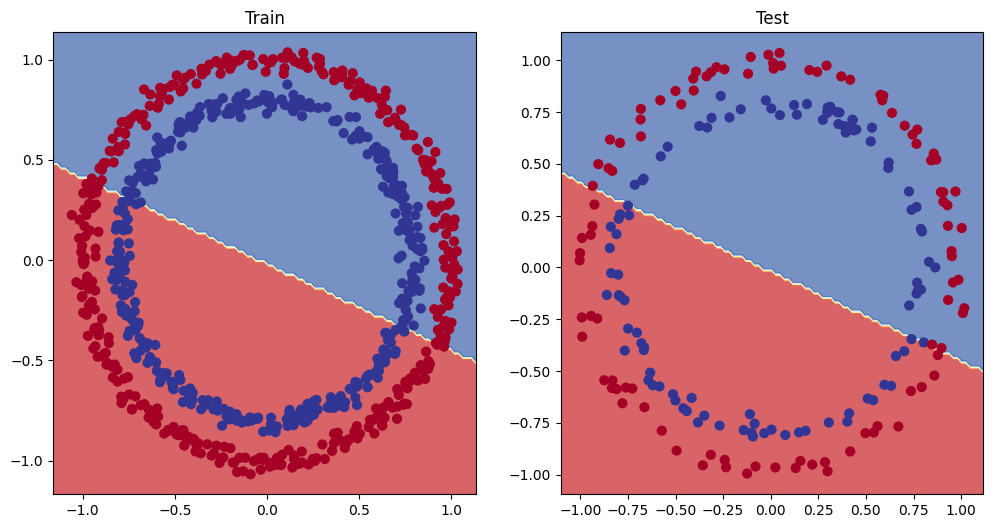

In [246]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

### Improving our model

In [247]:
class CircleModuleV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        # z = self.layer_1(x)
        # z = self.layer_2(z)
        # z = self.layer_3(z)
        return self.layer_3(self.layer_2(self.layer_1(x))) # this way of writing operations leverages speedups where possible
model_1 = CircleModuleV1()
model_1

CircleModuleV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [248]:
# create a lss function
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)


In [249]:
torch.manual_seed(42)

In [250]:
epochs = 1000

for epoch in range(epochs):
    model_1.train()

    # 1. forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    # 2. calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3 optimizer zero grad
    optimizer.zero_grad()

    # 4 loss backwras
    loss.backward()

    # 5 ptimizer step
    optimizer.step()

    ## testng
    model_1.eval()
    with torch.inference_mode():
        # 1. forward pass\
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2 calculate loss
        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

# 4 print out whats happening
    if epoch % 100 == 0:
        print(f"Epoch: {epochs} | Loss: {loss:5f} | Acc: {acc:2f}% | Test loss: {test_loss:5f} | Test acc: {test_acc:2f}%")
       




Epoch: 1000 | Loss: 0.693955 | Acc: 50.875000% | Test loss: 0.692615 | Test acc: 51.000000%
Epoch: 1000 | Loss: 0.693048 | Acc: 50.375000% | Test loss: 0.693790 | Test acc: 48.000000%
Epoch: 1000 | Loss: 0.692986 | Acc: 51.125000% | Test loss: 0.694373 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692981 | Acc: 51.625000% | Test loss: 0.694577 | Test acc: 45.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.125000% | Test loss: 0.694645 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694668 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694676 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694678 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694679 | Test acc: 46.000000%
Epoch: 1000 | Loss: 0.692980 | Acc: 51.000000% | Test loss: 0.694679 | Test acc: 46.000000%


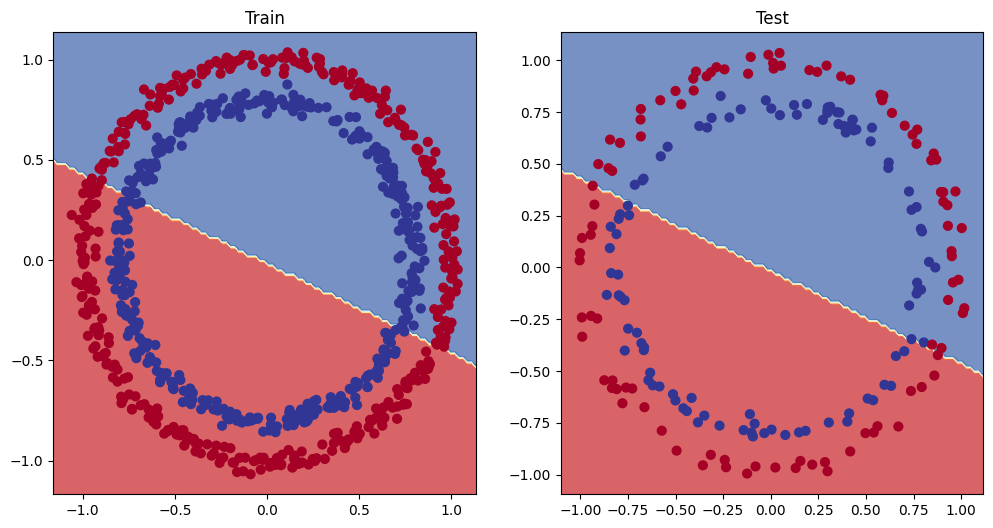

In [251]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

The nn.Linear alone is not making our model learn anything. We need to combine linear and non-linear functions to get good result

### Re-creating the non-linear data

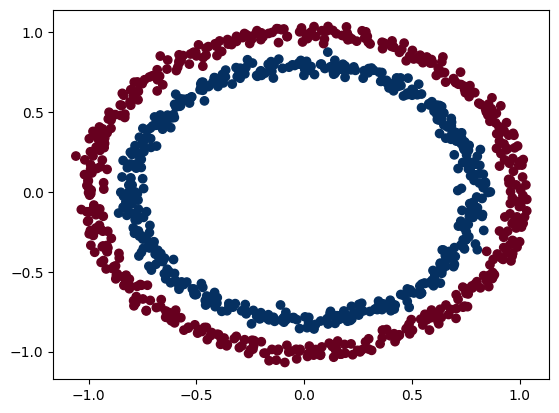

In [252]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000
X, y = make_circles(n_samples, noise=0.03, random_state=42)


plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu)

In [253]:
from sklearn.model_selection import train_test_split

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

Building a model with non-linearity

In [254]:
class CircleModuleV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
    
model_2=CircleModuleV2()
model_2

CircleModuleV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [255]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [256]:
len(X_test), len(y_test)

(200, 200)

In [257]:
torch.manual_seed(42)
EPOCHS = 1000
for epoch in range (EPOCHS):
    model_2.train()
    y_logits = model_2(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()
    optimizer.step()


    #testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Training Loss: {loss:4f} | Acc: {acc:2f}% | Test loss: {test_loss:4f} | Test Acc: {test_acc}%")

Epoch: 0 | Training Loss: 0.692946 | Acc: 50.000000% | Test loss: 0.693188 | Test Acc: 50.0%
Epoch: 100 | Training Loss: 0.691153 | Acc: 52.875000% | Test loss: 0.691024 | Test Acc: 52.5%
Epoch: 200 | Training Loss: 0.689774 | Acc: 53.375000% | Test loss: 0.689396 | Test Acc: 55.00000000000001%
Epoch: 300 | Training Loss: 0.687950 | Acc: 53.000000% | Test loss: 0.687232 | Test Acc: 56.00000000000001%
Epoch: 400 | Training Loss: 0.685168 | Acc: 52.750000% | Test loss: 0.684115 | Test Acc: 56.49999999999999%
Epoch: 500 | Training Loss: 0.681022 | Acc: 52.750000% | Test loss: 0.679412 | Test Acc: 56.49999999999999%
Epoch: 600 | Training Loss: 0.675149 | Acc: 54.500000% | Test loss: 0.672851 | Test Acc: 56.00000000000001%
Epoch: 700 | Training Loss: 0.666589 | Acc: 58.375000% | Test loss: 0.663216 | Test Acc: 59.0%
Epoch: 800 | Training Loss: 0.651595 | Acc: 64.000000% | Test loss: 0.647569 | Test Acc: 67.5%
Epoch: 900 | Training Loss: 0.623623 | Acc: 74.000000% | Test loss: 0.621453 | Tes

In [258]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

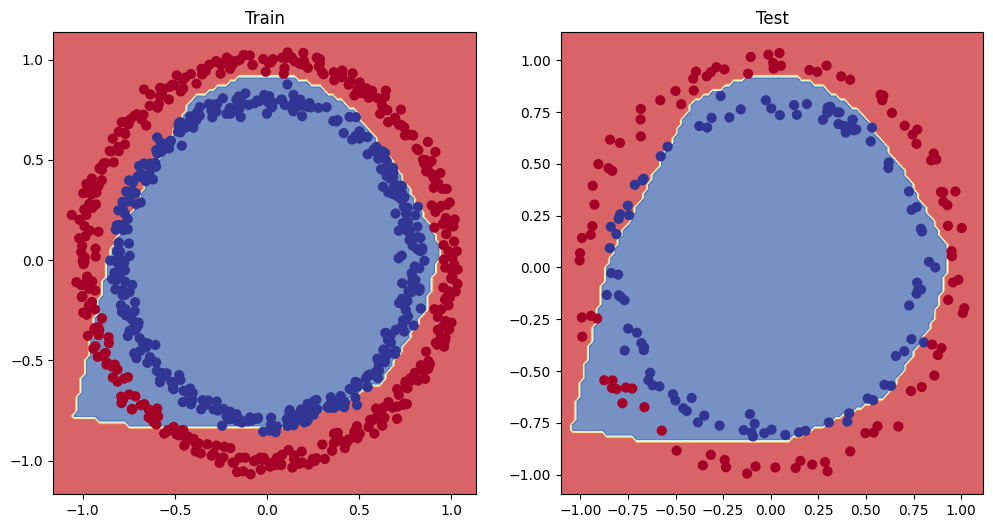

In [259]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

### Replicating non-linear activation function

In [260]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype=torch.float32)
A.dtype

torch.float32

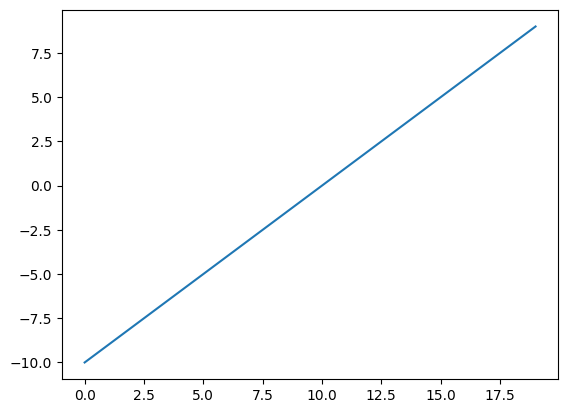

In [261]:
plt.plot(A)

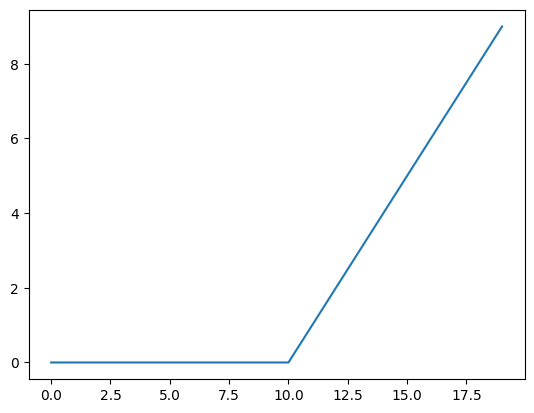

In [262]:
plt.plot(torch.relu(A))

In [263]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0), x) #inputs must be tensors

relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

In [264]:
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

Relu basically convert negative values to 0 and leaves all positive values as they are

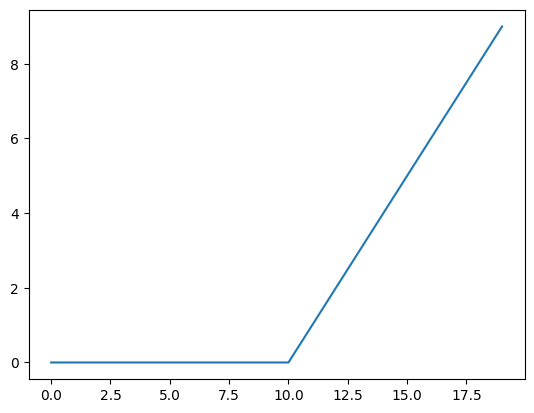

In [265]:
plt.plot(relu(A))

In [266]:
#Replicating sigmoid

def sigmoid(x):
    return 1 / (1+torch.exp(-x))

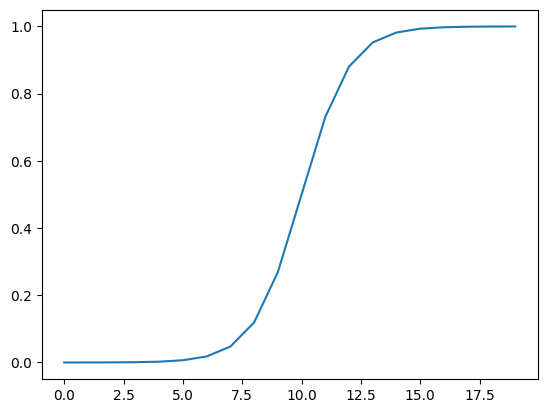

In [267]:
plt.plot(torch.sigmoid(A))

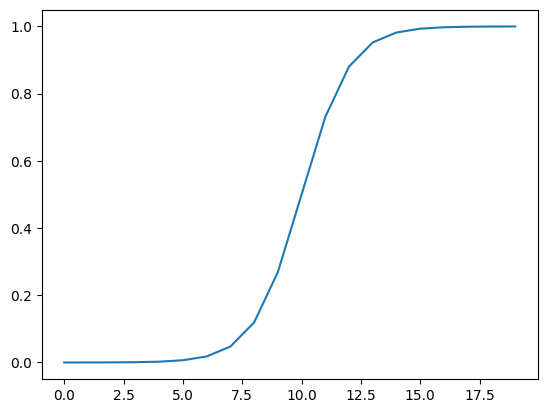

In [268]:
plt.plot(sigmoid(A))

## Putting it all together -- Multiclass classificatin

### Creating toy multi class data

In [303]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

# set hyperparameters for data
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED  = 42

# Create data
X_blob, y_blob = make_blobs(n_samples=1000, n_features=NUM_FEATURES, centers=NUM_CLASSES, cluster_std=1.5, random_state=RANDOM_SEED)

In [304]:
# turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob, y_blob, test_size=0.2, random_state=42)
len(X_blob_train), len(y_blob_train)

(800, 800)

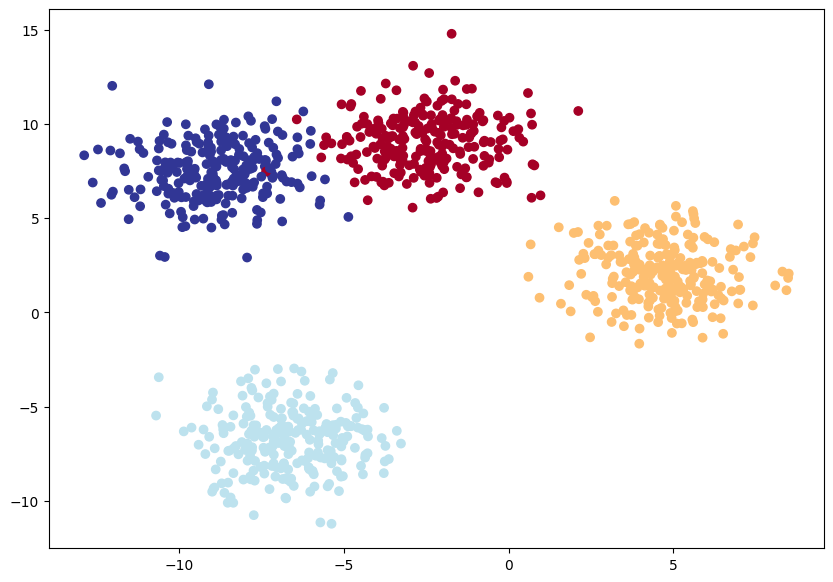

In [305]:
# plot data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)




### Building our model

In [306]:
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units = 8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            #nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features)
        )
    def forward(self, x):
        return self.linear_layer_stack(x)

model_3 = BlobModel(input_features=2, output_features=4, hidden_units=8)
model_3


BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

### Create loss function and optimizer

In [307]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_3.parameters(), lr=0.1)

In [308]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test)

y_logits[:5]

tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])

These raw values are logits.
* In order t evaluate and train and test our model, we need to convert our mdel's output(logits) to prediction probabilitirs and then to prediction labels
* To do this we use activation functin

In [309]:
y_blob_test[:5]


tensor([1, 3, 2, 1, 0])

In [310]:
# convert logits to pred probability
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])


tensor([[-1.2549, -0.8112, -1.4795, -0.5696],
        [ 1.7168, -1.2270,  1.7367,  2.1010],
        [ 2.2400,  0.7714,  2.6020,  1.0107],
        [-0.7993, -0.3723, -0.9138, -0.5388],
        [-0.4332, -1.6117, -0.6891,  0.6852]])
tensor([[0.1872, 0.2918, 0.1495, 0.3715],
        [0.2824, 0.0149, 0.2881, 0.4147],
        [0.3380, 0.0778, 0.4854, 0.0989],
        [0.2118, 0.3246, 0.1889, 0.2748],
        [0.1945, 0.0598, 0.1506, 0.5951]])


In [311]:
# convert our mdel's prediction probabilities to predictyion labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:5]

tensor([3, 3, 2, 1, 3])

In [312]:
len(y_logits), len(y_blob_train)

(200, 800)

In [313]:
# Use CrossEntropyLoss (if not already using it)
loss_fn = torch.nn.CrossEntropyLoss()

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_blob_train)  # model outputs raw logits
    y_pred = y_logits.argmax(dim=1)   # Get predictions directly from logits (no softmax)

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)  # CrossEntropyLoss expects raw logits
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_blob_test)
        test_pred = test_logits.argmax(dim=1)  # Get predictions directly from logits
        
        # 2. Calculate test loss and accuracy
        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test, y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 1.04324, Acc: 65.50% | Test Loss: 0.57861, Test Acc: 95.50%
Epoch: 10 | Loss: 0.14398, Acc: 99.12% | Test Loss: 0.13037, Test Acc: 99.00%
Epoch: 20 | Loss: 0.08062, Acc: 99.12% | Test Loss: 0.07216, Test Acc: 99.50%
Epoch: 30 | Loss: 0.05924, Acc: 99.12% | Test Loss: 0.05133, Test Acc: 99.50%
Epoch: 40 | Loss: 0.04892, Acc: 99.00% | Test Loss: 0.04098, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04295, Acc: 99.00% | Test Loss: 0.03486, Test Acc: 99.50%
Epoch: 60 | Loss: 0.03910, Acc: 99.00% | Test Loss: 0.03083, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03643, Acc: 99.00% | Test Loss: 0.02799, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03448, Acc: 99.00% | Test Loss: 0.02587, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03300, Acc: 99.12% | Test Loss: 0.02423, Test Acc: 99.50%


In [315]:
model_3.eval()
with torch.inference_mode():
    y_logits = model_3(X_blob_test)
y_logits[:10]

tensor([[  4.3377,  10.3539, -14.8948,  -9.7642],
        [  5.0142, -12.0371,   3.3860,  10.6699],
        [ -5.5885, -13.3448,  20.9894,  12.7711],
        [  1.8400,   7.5599,  -8.6016,  -6.9942],
        [  8.0727,   3.2906, -14.5998,  -3.6186],
        [  5.5844, -14.9521,   5.0168,  13.2891],
        [ -5.9739, -10.1913,  18.8655,   9.9179],
        [  7.0755,  -0.7601,  -9.5531,   0.1736],
        [ -5.5919, -18.5990,  25.5310,  17.5799],
        [  7.3142,   0.7197, -11.2017,  -1.2011]])

In [316]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_pred_probs[:10]

tensor([[2.4332e-03, 9.9757e-01, 1.0804e-11, 1.8271e-09],
        [3.4827e-03, 1.3697e-10, 6.8363e-04, 9.9583e-01],
        [2.8657e-12, 1.2266e-15, 9.9973e-01, 2.6959e-04],
        [3.2692e-03, 9.9673e-01, 9.5435e-08, 4.7619e-07],
        [9.9168e-01, 8.3089e-03, 1.4120e-10, 8.2969e-06],
        [4.5039e-04, 5.4287e-13, 2.5532e-04, 9.9929e-01],
        [1.6306e-11, 2.4030e-13, 9.9987e-01, 1.3003e-04],
        [9.9860e-01, 3.9485e-04, 5.9937e-08, 1.0045e-03],
        [3.0436e-14, 6.8303e-20, 9.9965e-01, 3.5218e-04],
        [9.9843e-01, 1.3657e-03, 9.0767e-09, 2.0006e-04]])

In [319]:
# Go from lgits to prediction probs
y_pred_probs = torch.argmax(y_pred_probs, dim=1)
y_pred_probs[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

now we are good to go

In [317]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

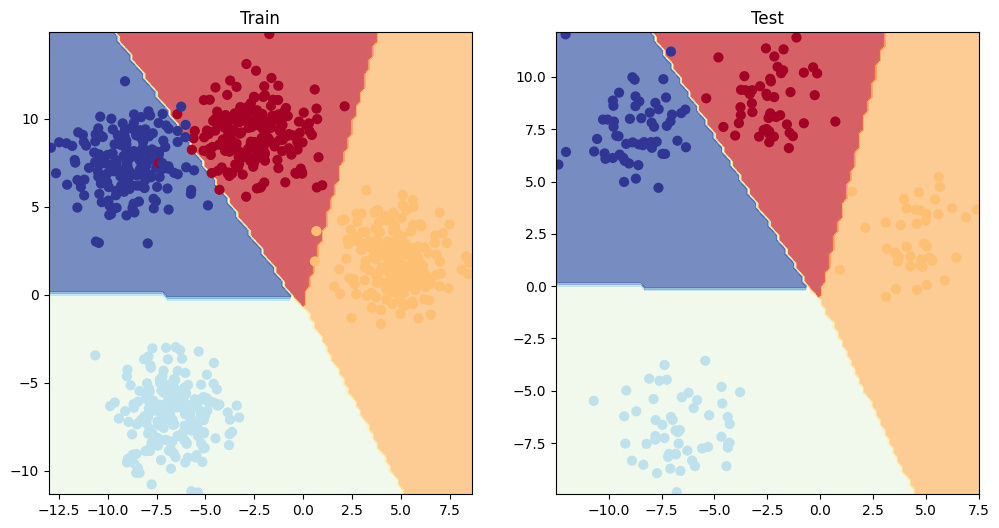

In [314]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_3, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_blob_test, y_blob_test)